# Supplementary Information: Holmes *et al.* 2017

# 5. Partial pooling

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pystan
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Supplementary_Info/SI_Holmes_etal_2016/venv-SI_Holmes_2016/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model

We have, so far, restricted ourselves to pooled or unpooled linear fits. This has had the effect of either: maximising the effect of *bias* (for the pooled model) - where a single model can't possibly fit every circumstance perfectly; or maximising the effect of *variance* (for the unpooled model) - where we run the risk of overfitting our model to occasionally unreliably outlying data by having completely independent linear fits for each group (*probe ID*)

An alternative to this is to assume that the parameters of the model for each *probe ID* are drawn from some parent distribution, in a *hierarchical model*. This is in effect equivalent to fitting a different linear model to each *probe ID*, but specifying that the range of parameters for each model is constrained to a certain distribution of values.

**NOTE:** it is entirely possible that our choice of distribution, and choice of grouping strategy, are inappropriate for the data.

We therefore construct the following model of the experiment:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_i + \epsilon_i$$
$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta_{j[i]} \sim N(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\sigma_{\alpha} \sim U(0, 100)$$
$$\sigma_{\beta} \sim U(0, 100)$$

* $y_i$: measured intensity output on the array for probe $i$ (specific to each replicate)
* $x_i$: measured intensity input on the array for probe $i$ (specific to each replicate)
* $\alpha_{j[i]}$: the linear intercept, this is a constant 'offset' for all *output* measurements relative to *input* measurements, but it differs for each *probe ID*; this is drawn from a Normal distribution $\sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$
* $\mu_{\alpha}$: the mean offset for all *probe ID*s
* $\sigma_{\alpha}$: the standard deviation of the offset for all *probe ID*s - sampled from a Uniform distribution $U(0, 100)$
* $\beta_{j[i]}$: the linear slope, this is the relative change in measured intensity between *input* and *output* intensities *at the probe ID level* - it differs for each *probe ID*; this is drawn from a Normal distribution $\sim N(\mu_{\beta}, \sigma_{\beta}^2)$
* $\mu_{\beta}$: the mean slope for all *probe ID*s
* $\sigma_{\beta}$: the standard deviation of the slope for all *probe ID*s - sampled from a Uniform distribution $U(0, 100)$
* $\epsilon_i$: error in the model prediction for probe $i$

### Stan model construction and fit

We need to define `data`, `parameters` and our `model` for `Stan`.

In the `data` block, we have:

* `N`: `int`, the number of data points)
* `J`: `int`, the number of unique probe IDs (`J` < `N`)
* `probe`: `int[N]`, an index list of probe identities - one index representing six probe measurements (i.e. three control, three treatment) - there are `J` probes
* `x`: `vector[N]`, the input log(intensity) values
* `y`: `vector[N]`, the output log(intensity) values

In the `parameter` block, we have:

* `a`: `real vector[J]`, representative input log(intensity)
* `mu_a`: `real`, an unconstrained value to be fit that represents the mean offset for each probe ID
* `b`: `real vector[J]`, effect on log(intensity) of passing through the experiment, specific to a probe ID
* `mu_b`: `real`, an unconstrained value to be fit that represents the mean slope for each probe ID
* `sigma`: `real<lower=0>`, the error in the prediction
* `sigma_a`: `real<lower=0,upper=100>`, standard deviation of the offset per probe ID
* `sigma_b`: `real<lower=0,upper=100>`, standard deviation of the slope per probe ID

We also define a `transformed parameter`:

* `y_hat[i] <- b[probe[i]] * x[i] + a[probe[i]]`: the linear relationship describing $\hat{y}$, our estimate of experimental output intensity, which is subject to variance `sigma`.

We define the model as:

$$\sigma_{\alpha} \sim U(0, 100)$$
$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\sigma_{\beta} \sim U(0, 100)$$
$$\beta_{j[i]} \sim N(\mu_{\beta}, \sigma_{\beta}^2)$$
$$y \sim N(\hat{y}, \sigma^2)$$


In [2]:
# load clean, normalised, indexed data
# data = pd.read_csv("output/normalised_array_data.tab", sep="\t")  # full dataset
data = pd.read_csv("output/reduced_normalised_indexed_array_data.tab", sep="\t")  # reduced dataset for test

# useful values
probe_ids = data['probe'].unique()
nprobes = len(probe_ids)

In [3]:
# define unpooled stan model
partial_model = """
data {
  int<lower=0> N;
  int<lower=0> J;
  int<lower=1, upper=J> probe[N];
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[J] a;
  vector[J] b;
  real mu_a;
  real mu_b;
  real<lower=0> sigma;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_b;
}
transformed parameters{
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] = a[probe[i]] + b[probe[i]] * x[i];
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal(mu_a, sigma_a);

  sigma_b ~ uniform(0, 100);
  b ~ normal(mu_b, sigma_b);

y ~ normal(y_hat, sigma);
}
"""

In [4]:
# relate python variables to stan variables
partial_data_dict = {'N': len(data),
                     'J': nprobes,
                     'probe': data['probe_index'] + 1,
                     'x': data['log_input'],
                     'y': data['log_output']}

In [5]:
# run stan fit
partial_fit = pystan.stan(model_code=partial_model,
                          data=partial_data_dict,
                          iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b74c343a6ad3ac4d1437610cc5ba72eb NOW.


## Inspecting the fit

Now there are (for the full dataset) now approximately 44000 parameters describing the slope and intercept for individual probe IDs. This is more than we can look at directly but we can continue to get an estimate of the range of values those slopes and look at the potential for outliers - specific probe IDs that look as though they may deviate quite far from the mean of all estimates.

In [6]:
# Get fits to alpha and beta by probe ID
alpha_estimates = pd.Series(partial_fit['a'].mean(0), index=probe_ids)
alpha_se = pd.Series(partial_fit['a'].std(0), index=probe_ids)
beta_estimates = pd.Series(partial_fit['b'].mean(0), index=probe_ids)
beta_se = pd.Series(partial_fit['b'].std(0), index=probe_ids)

In [7]:
# Inspect the estimates
alpha_estimates.head()

A_07_P038676    0.176336
A_07_P033759    0.676139
A_07_P033727    0.377327
A_07_P033715    0.397505
A_07_P040893    0.966504
dtype: float64

In [8]:
# Inspect the estimates
beta_estimates.head()

A_07_P038676    0.913194
A_07_P033759    0.913474
A_07_P033727    0.913374
A_07_P033715    0.913356
A_07_P040893    0.914201
dtype: float64

### Intercept $\alpha_{j[i]}$

Taking the intercept first, we can get an overview of the mean and standard error of $\alpha$:

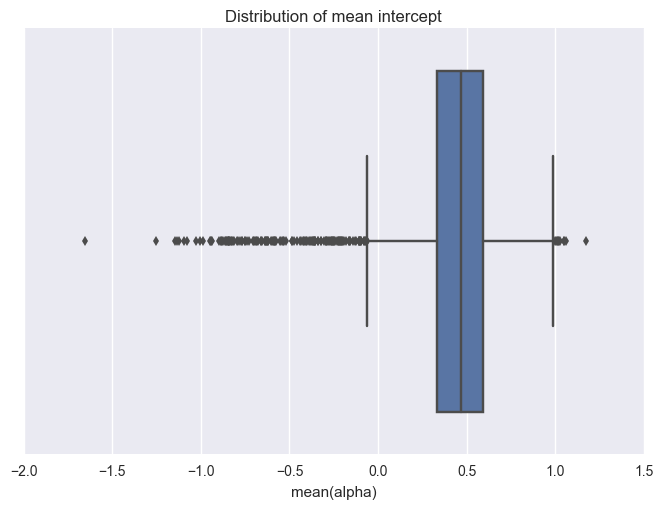

In [9]:
# Plot means distribution
g = sns.boxplot(alpha_estimates)
g.set_title("Distribution of mean intercept")
g.set_xlabel("mean(alpha)");

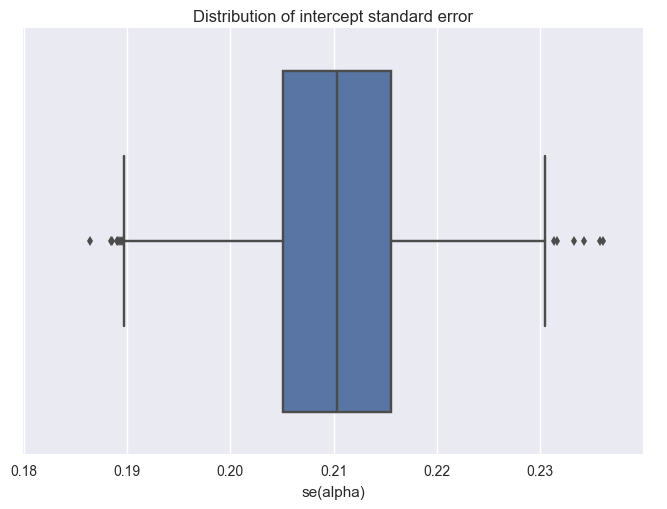

In [10]:
# Plot means distribution
g = sns.boxplot(alpha_se)
g.set_title("Distribution of intercept standard error")
g.set_xlabel("se(alpha)");

Compared to the unpooled model in particular, the distribution of intercepts is now rather tight, with a mean close to 25. However, the variance is also quite large, and we cannot say that our intercepts are different from zero:

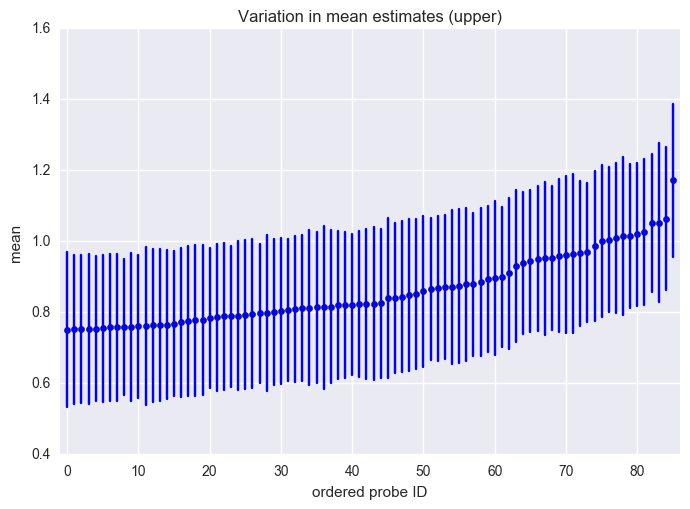

In [18]:
# errors for intercept outliers
tools.plot_threshold_errors(alpha_estimates, alpha_se, 0.75)

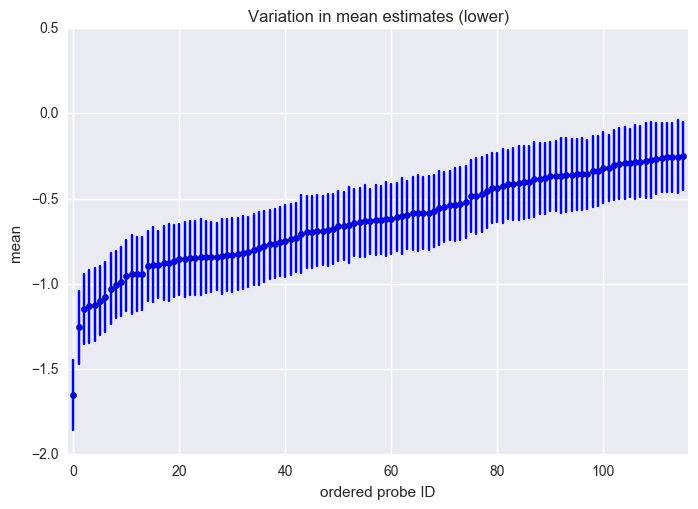

In [19]:
# errors for intercept outliers
tools.plot_threshold_errors(alpha_estimates, alpha_se, -0.25, upper=False)

### Slopes $\beta_{j[i]}$

The variation of slopes $\beta_{j[i]}$ by *probe ID* remain the most interesting estimates, as they are indicative of the way *output* intensity measurements depend on *input* intensity measurements, and could help identify genes that are advantageous or disadvantageous in our experiment.

In our previous fit, we saw several outlying values of $\beta_{j[i]}$, ranging quite far from unity, and that there was considerable error associated with the more extreme values.

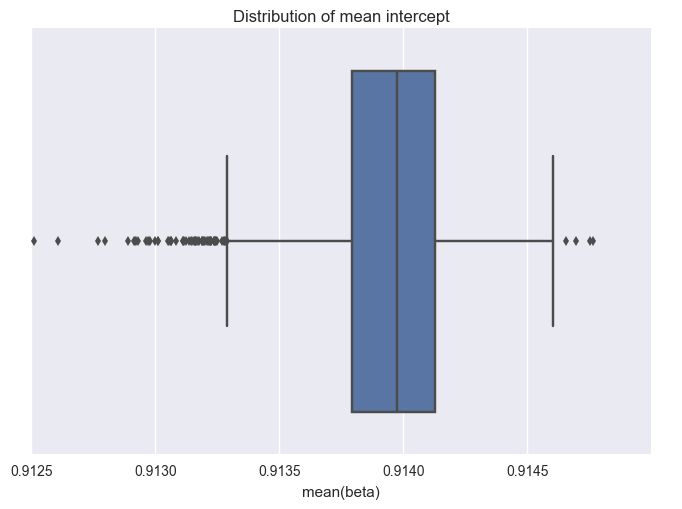

In [13]:
# Plot means distribution
g = sns.boxplot(beta_estimates)
g.set_title("Distribution of mean intercept")
g.set_xlabel("mean(beta)");

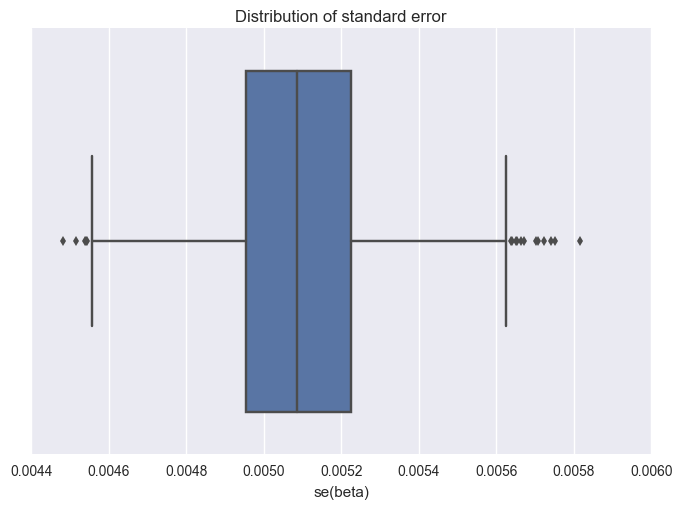

In [14]:
# Plot error distribution
g = sns.boxplot(beta_se)
g.set_title("Distribution of standard error")
g.set_xlabel("se(beta)");

With this partially-pooled model, we see that most values of $\beta_{j[i]}$ lie close to 0.8, and the number of outliers (and the size of the parameter) is reduced. The error in the estimate for slope is also much smaller, and it appears that no slopes are negative, or have errors of their estimates that imply they could take a zero value.

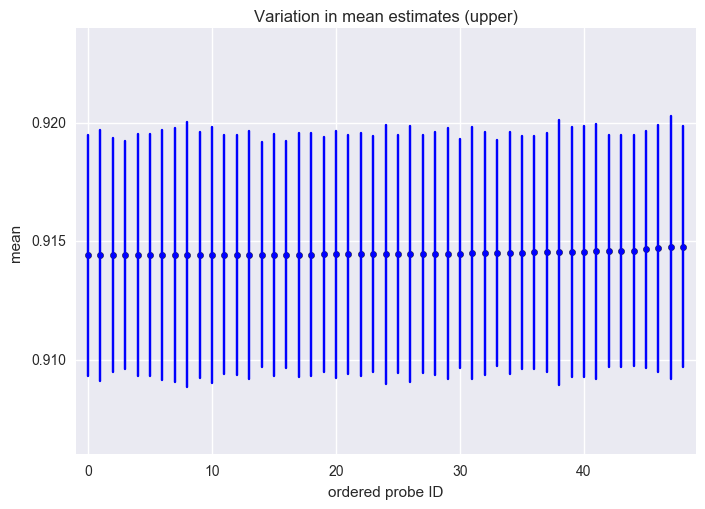

In [25]:
# errors for intercept outliers
tools.plot_threshold_errors(beta_estimates, beta_se, 0.9144)

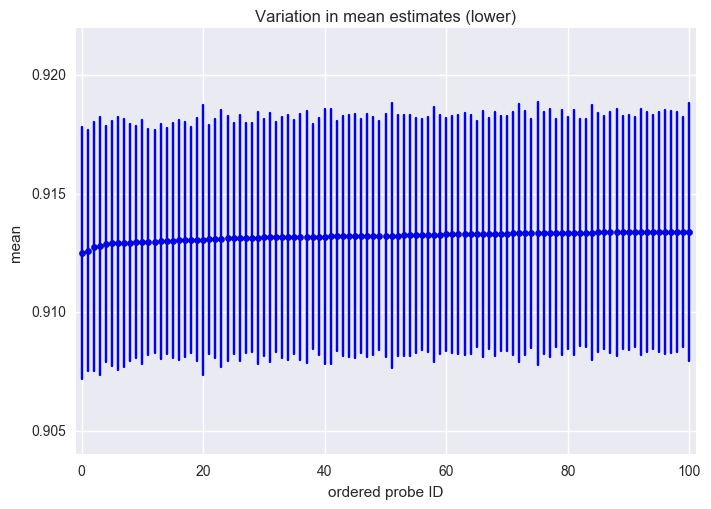

In [23]:
# errors for intercept outliers
tools.plot_threshold_errors(beta_estimates, beta_se, 0.9134, upper=False)

It seems that there are a couple of obvious outliers, but in general most *probe ID*s have a fairly steady relationship between *input* and *output* measured intensity. There are noticeable differences in estimated slope, but the greatest uncertainty now seems to lie with *probe ID* with estimated slopes close to the median value.

At this point, we still have not accounted for a number of other potential influences on model output, including the effect of *control* vs *treatment*.